In [11]:
import numpy as np
import random
import math
import copy
from DrawChart_3 import BarChart

class Ant(object):
    def __init__(self):
        self.path = []
        self.fitness = float('inf')
        self.delta = 0


class ACO:

    def __init__(self,src, dst, N, Max, K_paths, p, a, b, p0, Q, st):
        self.switches = [i for i in range(1,31)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.K_paths = K_paths
        self.p = p
        self.a = a
        self.b = b
        self.p0 = p0
        self.Q = Q
        self.colony = [Ant() for i in range(self.N)]
        self.condidates = []
        self.best = []
        self.pheromone = self.CreatePheromone()
        self.probability = self.CreateProbability()
        self.st = st
        self.values = []
    
    def CreatePheromone(self):
        pheromone = copy.deepcopy(self.adjacency)
        for sw_1 in self.adjacency.keys():
            for sw_2 in self.adjacency[sw_1].keys():
                pheromone[sw_1][sw_2] = 1/self.weight_map[sw_1][sw_2]
        return pheromone

    def CreateProbability(self):
        probability = copy.deepcopy(self.adjacency)
        for sw_1 in self.adjacency.keys():
            for sw_2 in self.adjacency[sw_1].keys():
                probability[sw_1][sw_2] = 0
        return probability
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('metric_data_30.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreatePath(self):
        for i in range(self.N):
            path = []
            current_switch = self.src
            path.append(current_switch)
            while(current_switch!=self.dst):
                self.probability = self.CreateProbability()
                neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
                neighbor_switches = list(neighbor_switches)
                if(len(neighbor_switches)==0):
                    path.clear()
                    current_switch = self.src
                    path.append(current_switch)
                else:
                    current_switch = self.GetNextSwitch(neighbor_switches, current_switch)
                    path.append(current_switch)
            self.colony[i].path = copy.deepcopy(path)
            self.colony[i].fitness = self.Evaluate(self.colony[i].path)
            self.colony[i].delta = self.Q/self.colony[i].fitness

    def GetNextSwitch(self, neighbor_switches, current_switch):
        sum = 0
        for sw in neighbor_switches:
            x = self.pheromone[current_switch][sw]
            y = 1/(self.weight_map[current_switch][sw])
            z = pow(x,self.a)*pow(y,self.b)
            sum+=z
        prob = []
        for sw in neighbor_switches:
            x = self.pheromone[current_switch][sw]
            y = 1/(self.weight_map[current_switch][sw])
            z = pow(x,self.a)*pow(y,self.b)
            self.probability[current_switch][sw]=z/sum
            self.probability[sw][current_switch]=z/sum
            prob.append(z/sum)
        sw_max = 1
        prob_max = 0
        for sw in neighbor_switches:
            if(self.probability[current_switch][sw]>=prob_max):
                prob_max = self.probability[current_switch][sw]
                sw_max = sw
        p = np.random.rand()
        if(p <= self.p0):
            current_switch= sw_max
        else:
            sw = np.random.choice(neighbor_switches,p=prob)
            current_switch= sw
        return current_switch

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def UpdatePheromone(self):
        # update local
        for sw_1 in self.pheromone.keys():
            for sw_2 in self.pheromone[sw_1].keys():
                self.pheromone[sw_1][sw_2]=self.pheromone[sw_1][sw_2]*(1-self.p)
        for i in range(self.N):
            for j in range(len(self.colony[i].path) - 1):
                p1 = self.colony[i].path[j]
                p2 = self.colony[i].path[j + 1]
                self.pheromone[p1][p2] += self.p*self.colony[i].delta/len(self.switches)
                self.pheromone[p2][p1] += self.p*self.colony[i].delta/len(self.switches)
        # update global
        self.colony.sort(key=lambda x: x.fitness)
        for j in range(len(self.colony[0].path) - 1):
            p1 = self.colony[0].path[j]
            p2 = self.colony[0].path[j + 1]
            self.pheromone[p1][p2] = (1-self.p)*self.pheromone[p1][p2] + self.p*self.colony[0].delta
            self.pheromone[p2][p1] = (1-self.p)*self.pheromone[p2][p1] + self.p*self.colony[0].delta
     
    def MemorizeCondidates(self):
        # self.colony.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.colony)):
            dk_3 = False
            for ant in condidate:
                if(tuple(ant.path)==tuple(self.colony[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.colony[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))

    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for ant in self.best:
                if(tuple(ant.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
        
        for x in range(len(self.best)):
            self.values.append(self.best[x].fitness)

    def Do(self):
        for i in range(self.Max):
            self.CreatePath()
            self.UpdatePheromone()
            self.MemorizeCondidates()
        self.GetBest()

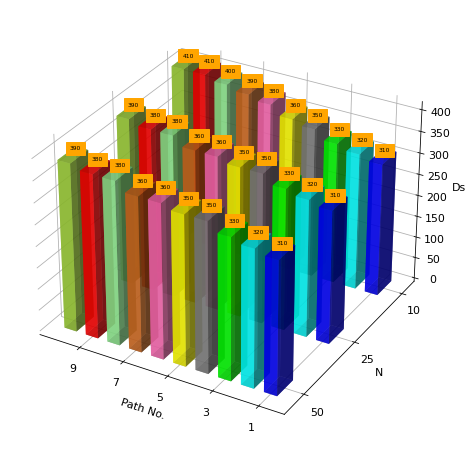

In [12]:
N = [10, 25, 50]
Max = 25
K_paths = 10
p = 0.2
a = 0.6
b = 0.4
p0 = 0.3
Q = 1
st = "ACO_N_2_chart"
pr = [str(i) for i in N]
pr.reverse()
pr.append("N")
alg = ACO(1, 19,N[0], Max, K_paths, p, a, b, p0, Q, st)
alg.Do()
alg1 = ACO(1, 19,N[1], Max, K_paths, p, a, b, p0, Q, st)
alg1.Do()
alg2 = ACO(1, 19,N[2], Max, K_paths, p, a, b, p0, Q, st)
alg2.Do()
chart = BarChart(alg2.values,alg1.values,alg.values,st,pr)
chart.Do()

In [13]:
print(alg.values)
print(alg1.values)
print(alg2.values)

[410, 410, 400, 390, 380, 360, 350, 330, 320, 310]
[390, 380, 380, 360, 360, 350, 350, 330, 320, 310]
[390, 380, 380, 360, 360, 350, 350, 330, 320, 310]


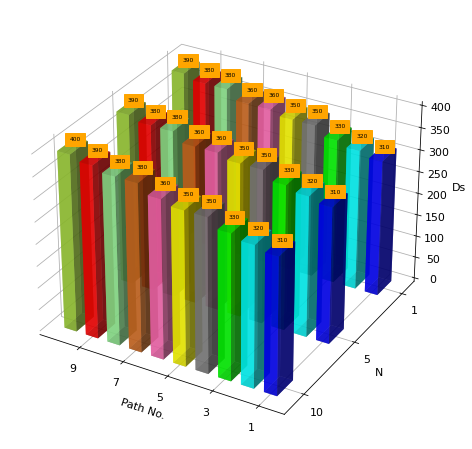

In [9]:
N = 30
Max = 25
K_paths = 10
p = 0.2
a = 0.6
b = 0.4
p0 = 0.3
Q = [1,5,10]
st = "ACO_N_2_chart"
pr = [str(i) for i in Q]
pr.reverse()
pr.append("N")
alg = ACO(1, 19,N, Max, K_paths, p, a, b, p0, Q[0], st)
alg.Do()
alg1 = ACO(1, 19,N, Max, K_paths, p, a, b, p0, Q[1], st)
alg1.Do()
alg2 = ACO(1, 19,N, Max, K_paths, p, a, b, p0, Q[2], st)
alg2.Do()
chart = BarChart(alg2.values,alg1.values,alg.values,st,pr)
chart.Do()

In [10]:
print(alg.values)
print(alg1.values)
print(alg2.values)

[390, 380, 380, 360, 360, 350, 350, 330, 320, 310]
[390, 380, 380, 360, 360, 350, 350, 330, 320, 310]
[400, 390, 380, 380, 360, 350, 350, 330, 320, 310]
